In [253]:
!conda activate pytorchenv

In [280]:
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.transforms import RandomCrop
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from random import randrange

In [255]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [256]:
image_path = r'C:\Users\Pau\Desktop\Neurosphere Annotations 2\export\images_ds4'
label_path = r'C:\Users\Pau\Desktop\Neurosphere Annotations 2\export\labels_ds4'
image_path = Path(image_path)
image_path = sorted(list(Path(image_path).iterdir()))

label_path = Path(label_path)
label_path = sorted(list(Path(label_path).iterdir()))


In [257]:
all_images=[]
for image in image_path:
    img = io.imread(image)
    all_images.append(img)

all_labels=[]
for label in label_path:
    lbl = io.imread(label)
    all_labels.append(lbl>0)


In [324]:
def show_images(img_list,figsize=20,binaries=[],titles=[],**kwargs):

    """Display a list of images in horizontal subplots"""
    assert type(img_list)==list
    fig,axs=plt.subplots(1,len(img_list),figsize=(figsize,figsize))
    [axi.set_axis_off() for axi in axs.ravel()]
    plt.axes='off'
    for i,img in enumerate(img_list):
        if i in binaries:
            im=axs[i].imshow(img,vmin=0,vmax=1,**kwargs)
        else:
            im=axs[i].imshow(img,**kwargs)
        plt.colorbar(im, ax=axs[i],fraction=0.046, pad=0.04)
    plt.show()


cropper = RandomCrop(size=256)
blurrer = T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5))
hflipper = T.RandomHorizontalFlip(p=0.5)
vflipper = T.RandomVerticalFlip(p=0.5)
    # custom dataset
class CellDataset():
    def __init__(self, images,labels, transforms=None):
        self.X = images
        self.Y=  labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = torch.Tensor(self.X[i])
        label=torch.Tensor(self.Y[i])
        stack=torch.stack((data,label))



        if self.transforms:
            data=1-data
            #data=blurrer(data)
            #pass

        stack=cropper(stack)

        # increase the number of 'merged' objects calculating the maximum projection of the current crop
        # and a crop genereted from a different, randomly selected image
        # NOTE: brightfield images might not be suitable to apply this method

        #if self.transforms:
        #    nRandom = i
        #    while nRandom == i:
        #        nRandom = randrange(len(self.X)-1)
            
        #    stack2=torch.stack((torch.Tensor(self.X[nRandom]),torch.Tensor(self.Y[nRandom])))
        #    stack = torch.maximum(stack, cropper(stack2))
        #    stack[1]=stack[1]>0
        #    show_images([stack[0], stack[1]])

        if self.transforms:
            stack=vflipper(stack)
            stack=hflipper(stack)

        data=stack[0][None,]
        label=stack[1][None,].float()

        return data,label

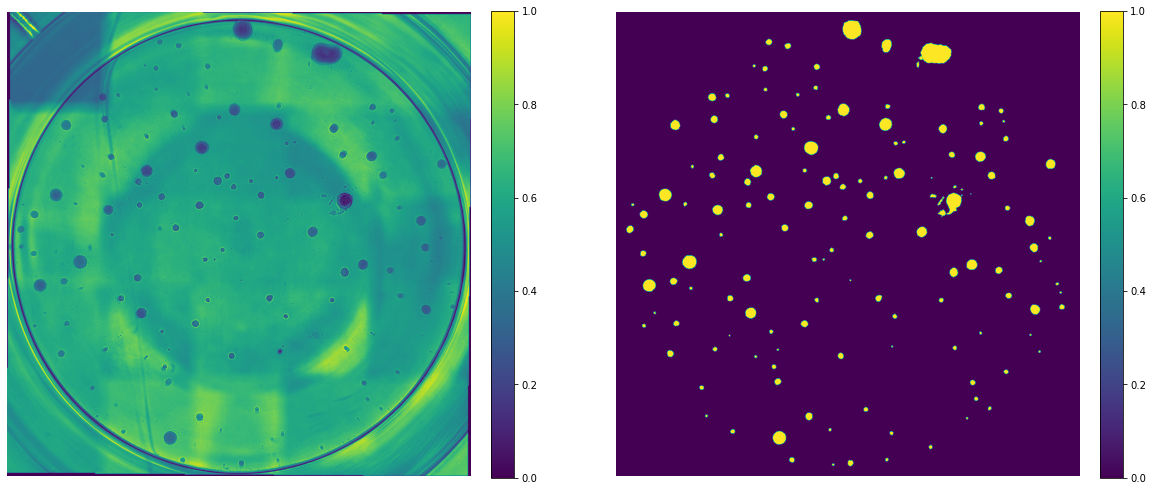

In [325]:
show_images([all_images[3],all_labels[3]])

In [327]:
train_data = CellDataset(all_images[:10], all_labels[:10],transforms=True)
test_data = CellDataset(all_images[10:], all_labels[10:],transforms=False)
train_loader = DataLoader(train_data, batch_size=3, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

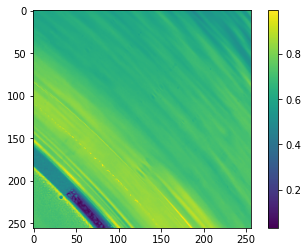

In [334]:
plt.imshow(next(iter(train_loader))[0][0][0])
plt.colorbar()

In [329]:

class DoubleConvSame(nn.Module):
    def __init__(self, c_in, c_out):
        super(DoubleConvSame, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

 

    def forward(self, x):

        return self.conv(x)

 

class UNet(nn.Module):

    def __init__(self, c_in, c_out):

        super(UNet, self).__init__()

 

        self.conv1 = DoubleConvSame(c_in=c_in, c_out=64)

        self.conv2 = DoubleConvSame(c_in=64, c_out=128)

        self.conv3 = DoubleConvSame(c_in=128, c_out=256)

        self.conv4 = DoubleConvSame(c_in=256, c_out=512)

        self.conv5 = DoubleConvSame(c_in=512, c_out=1024)

 

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

 

        self.up1 = nn.ConvTranspose2d(

            in_channels=1024, out_channels=512, kernel_size=2, stride=2

        )

        self.up2 = nn.ConvTranspose2d(

            in_channels=512, out_channels=256, kernel_size=2, stride=2

        )

        self.up3 = nn.ConvTranspose2d(

            in_channels=256, out_channels=128, kernel_size=2, stride=2

        )

        self.up4 = nn.ConvTranspose2d(

            in_channels=128, out_channels=64, kernel_size=2, stride=2

        )

 

        self.up_conv1 = DoubleConvSame(c_in=1024, c_out=512)

        self.up_conv2 = DoubleConvSame(c_in=512, c_out=256)

        self.up_conv3 = DoubleConvSame(c_in=256, c_out=128)

        self.up_conv4 = DoubleConvSame(c_in=128, c_out=64)

 

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1)

 

    def forward(self, x):

        """ENCODER"""

 

        c1 = self.conv1(x)

        p1 = self.pool(c1)

 

        c2 = self.conv2(p1)

        p2 = self.pool(c2)

 

        c3 = self.conv3(p2)

        p3 = self.pool(c3)

 

        c4 = self.conv4(p3)

        p4 = self.pool(c4)

        """BOTTLE-NECK"""

 

        c5 = self.conv5(p4)

        """DECODER"""

 

        u1 = self.up1(c5)

        cat1 = torch.cat([u1, c4], dim=1)

        uc1 = self.up_conv1(cat1)

 

        u2 = self.up2(uc1)

        cat2 = torch.cat([u2, c3], dim=1)

        uc2 = self.up_conv2(cat2)

 

        u3 = self.up3(uc2)

        cat3 = torch.cat([u3, c2], dim=1)

        uc3 = self.up_conv3(cat3)

 

        u4 = self.up4(uc3)

        cat4 = torch.cat([u4, c1], dim=1)

        uc4 = self.up_conv4(cat4)

 

        outputs = self.conv_1x1(uc4)

 

        return outputs

In [308]:
torch.save(model,"myfirstunet.pth")

In [264]:
#model=torch.load("myfirstunet.pth")

In [265]:
model=UNet(1,1).to(device)
loss_fn = nn.BCELoss()
sig = nn.Sigmoid()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [266]:
def train_epoch(NN, device, dataloader, loss_fn, optimizer):

    NN.train()

    train_loss = []

    for image_batch,labels_batch, in dataloader:

        imgs=image_batch.to(device)

        labels=labels_batch.to(device)

        output = NN(imgs)

        loss =loss_fn(sig(output),labels)

        # Backward pass

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)



def test_epoch(NN, device, dataloader, loss_fn, optimizer):

    NN.eval()

    test_loss = []

    for image_batch,labels_batch, in dataloader:

        imgs=image_batch.to(device)

        labels=labels_batch.to(device)#.squeeze(1)

        output = NN(imgs)

        loss = loss_fn(sig(output),labels)

        test_loss.append(loss.detach().cpu().numpy())




    img1=imgs.detach().cpu().numpy()[0][0]

    label1=labels.detach().cpu().numpy()[0][0]

    output1=output.detach().cpu().numpy()[0][0]




    show_images([img1,label1,output1],binaries=[])
    print(loss)

    return np.mean(test_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

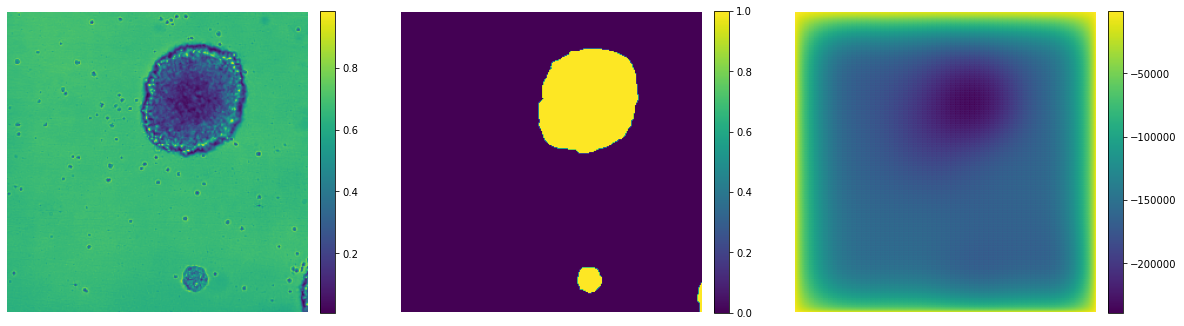

  0%|          | 1/1000 [00:07<2:06:44,  7.61s/it]

tensor(9.9503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


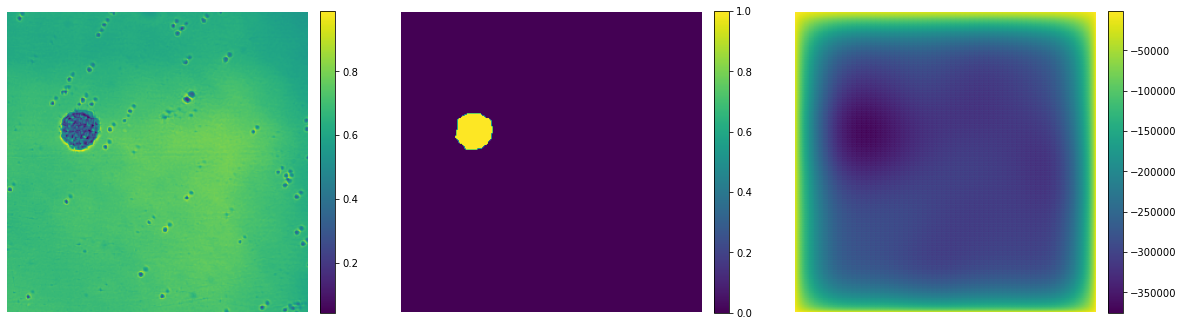

  0%|          | 2/1000 [00:14<1:59:05,  7.16s/it]

tensor(1.1963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 2/1000 [00:20<2:46:39, 10.02s/it]


KeyboardInterrupt: 

In [335]:
train_loss=[]
test_loss=[]
for epoch in tqdm(range(1000)):
    train_loss.append(train_epoch(model, device, train_loader, loss_fn, optimizer))
    test_loss.append(test_epoch(model, device, test_loader, loss_fn, optimizer))

In [ ]:
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()

In [ ]:
def moving_average(x, w):

    return np.convolve(x, np.ones(w), 'valid') /w
    

def plot_average(train,test,clip=99,window_size=100):

    fig=plt.figure(figsize=(10,10))

    clip_val=np.percentile(test,[clip])

    test=np.clip(test,0,clip_val[0])

    clip_val=np.percentile(train,[clip])

    train=np.clip(train,0,clip_val[0])

    plt.plot(moving_average(test,window_size),label="test")

    plt.plot(moving_average(train,window_size),label="train")

    plt.legend()
    plt.show()

    return fig

In [ ]:
plot_average(train_loss, test_loss)